In [26]:
import numpy as np
import matplotlib.pyplot as plt
import wradlib as wrl
import xarray as xr
import pyart
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from pyhail import hdr, mesh_grid, mesh_ppi, common, hsda, hacc
import matplotlib.colors as colors
import shapefile as shp
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
from netCDF4 import Dataset, num2date, date2num
import wrf
from matplotlib.cm import get_cmap
from datetime import datetime
from pprint import pprint
from pysteps import io, motion, nowcasts, rcparams, verification
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field, quiver
import os
import glob
import csv
import geopandas
from matplotlib_scalebar.scalebar import ScaleBar
from geodatasets import get_path

from pandas import DataFrame

import tempfile
import shutil

from metpy.calc import potential_temperature, saturation_vapor_pressure
from metpy.plots import SkewT
from metpy.units import units
import metpy.calc as mpcalc

from cartopy.feature import NaturalEarthFeature
from cartopy import crs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

warnings.filterwarnings('ignore')

from wrf import getvar, vertcross, interplevel

In [27]:
def plt_skewT(lon, lat, fname):
#lat_lon = [48.856, 2.352]
    wrfin = Dataset(fname,'r')
    cape, cin, LCL, LFC = calculate_cape_at_location(lon, lat ,fname)
    x_y = wrf.ll_to_xy(wrfin, lat, lon)

    p1 = wrf.getvar(wrfin,"pressure",timeidx=0)
    T1 = wrf.getvar(wrfin,"tc",timeidx=0)
    Td1 = wrf.getvar(wrfin,"td",timeidx=0)
    u1 = wrf.getvar(wrfin,"ua",timeidx=0)
    v1 = wrf.getvar(wrfin,"va",timeidx=0)

    p = p1[:,x_y[0],x_y[1]] * units.hPa
    T = T1[:,x_y[0],x_y[1]] * units.degC
    Td = Td1[:,x_y[0],x_y[1]] * units.degC
    u = v1[:,x_y[0],x_y[1]] * units('m/s')
    v = u1[:,x_y[0],x_y[1]] * units('m/s')

# Example of defining your own vertical barb spacing
    fig = plt.figure(figsize=(10,10))
    skew = SkewT(fig=fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, T, 'r')
    skew.plot(p, Td, 'g')
    
# Set spacing interval--Every 50 mb from 1000 to 100 mb
    my_interval = np.arange(100, 1000, 50) * units('mbar')

# Get indexes of values closest to defined interval
    ix = mpcalc.resample_nn_1d(p, my_interval)

# Plot only values nearest to defined interval values
    skew.plot_barbs(p[ix], u[ix], v[ix])

# Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-60, 40)
    skew.ax.set_xlabel('Temperature ($^\circ$C)')
    skew.ax.set_ylabel('Pressure (hPa)')
    #fig.text(0.5, 0,5, f"CAPE={cape}", ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))
    table_data = [['CAPE', f'{cape:.2f} J/kg'],
                  ['CIN', f'{cin:.2f} J/kg'],
                  ['LCL', f'{LCL:.2f} m'],
                  ['LFC', f'{LFC:.2f} m']]
    table = plt.table(cellText=table_data, loc=(0.3,0.5), 
                      colWidths=[0.2, 0.2], cellLoc='center', 
                      bbox=[0.7, 0.8, 0.25, 0.16], )
                      #cellColours=[['white', 'white'],['white', 'white']])
    for key, cell in table.get_celld().items():
        cell.set_facecolor('white')  # Change the color as needed
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

#plt.savefig('SkewT_Advanced.png', bbox_inches='tight')
def calculate_cape_at_location(lon, lat, fname):
    # Load WRF data
    wrf_data = Dataset(fname, 'r')
    #print(lon,lat)

    # Convert lon, lat to grid indices
    ix, iy = wrf.ll_to_xy(wrf_data, lat, lon, timeidx=0)
    #print(ix,iy)

    # Step 2: Extract Relevant Variables
    tk = getvar(wrf_data, "tk", timeidx=0)
    td = getvar(wrf_data, "td", timeidx=0)
    pp = getvar(wrf_data, "pres", timeidx=0)

    # Step 4: Loop over grid indices and calculate CAPE
    mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(pp[:, ix, iy], tk[:, ix, iy], td[:, ix, iy],
                                                           depth=150 * units.hPa)
    mucape, mucin = mpcalc.most_unstable_cape_cin(pp[:, ix, iy], tk[:, ix, iy], td[:, ix, iy],
                                                      depth=150 * units.hPa)

    cape2d =  getvar(wrf_data, "cape_2d")
    #cape = cape2d[0,ix,iy]
    LCL  = cape2d[2,ix,iy]
    LFC  = cape2d[3,ix,iy]
    cape = mucape.magnitude
    cin  = mucin.magnitude

    wrf_data.close()

    return cape, cin, LCL, LFC

In [28]:
casename = [ '2401', '1703', '2403', '2204' ]
date	= [ '2020-01-24', '2020-03-17', '2020-03-24', '2020-04-22' ]
mp		= [ [ '008', '009', '101', '102' ],
			[ '008', '009', '101', '102' ],
			[ '008', '009', '101', '102' ],
			[ '008', '000', '101', '000' ] ]
nullmp 	= '000'
fd_wrf 	= ["./wrf/raw/2020012312/mp.",
           "./wrf/raw/2020031612/mp.",
           "./wrf/raw/2020032312/mp.",
           "./wrf/raw/2020042112/mp." ]
fn_wrf  = [ "/wrfout_d03_2020-01-24_", 
			"/wrfout_d03_2020-03-17_",
			"/wrfout_d03_2020-03-24_",
			"/wrfout_d03_2020-04-22_" ]

snd		= ['48820_202001241200.txt',
           '48820_202003170000.txt',
           '48820_202003241200.txt',
           '48820_202004221200.txt']
fd_radar = ["./radar/data/20200124/",
            "./radar/data/20200317/PHADIN/",
            "./radar/data/20200324/",
            "./radar/data/20200422/" ]
slen	= [ 25, 32, 25, 25 ]
elen 	= [ 35, 42, 35, 35 ]
fn_radar = [ 'PHA200124','PHA200317','PHA200324','PHA200422' ]

h0_rd = [ 5, 10, 11, 9  ]
h1_rd = [ 9, 18, 15, 12 ]
nhour_rd = [ 4, 8, 4, 3 ]

maxlat = 23
minlat = 20
maxlon = 105
minlon = 102

#   Parameter
hca_hail_idx = [6, 7, 8]
shp_vn = "./radar/gadm40_VNM_1"
#max_lat = 22.75
#min_lat = 20.75
#min_lon = 102.5
#max_lon = 104.5
#####	Assign some variable
com_grid={}
com_grid['lonmin']=102
com_grid['lonmax']=105
com_grid['latmin']=20
com_grid['latmax']=23
com_grid['reslu_horiz']=801
com_grid['reslu_vert']=21
bbox = [101,17,109,25]
d_lon = 801
d_lat = 801

ndims = (21, 401, 401)
nmax = ((0.,20000.),(-300000.,300000.),(-300000.,300000.))
fld = ['MESH','radar_echo_classification','HSDA']
nf = 0

#scales = [2, 10, 20, 40, 53, 60, 120]
scales = list(range(1,121))
scale2 = [5, 10, 20, 40, 60, 80, 119]
thr = 1.0     # nonsevere > 5mm
###########################################

case = 1


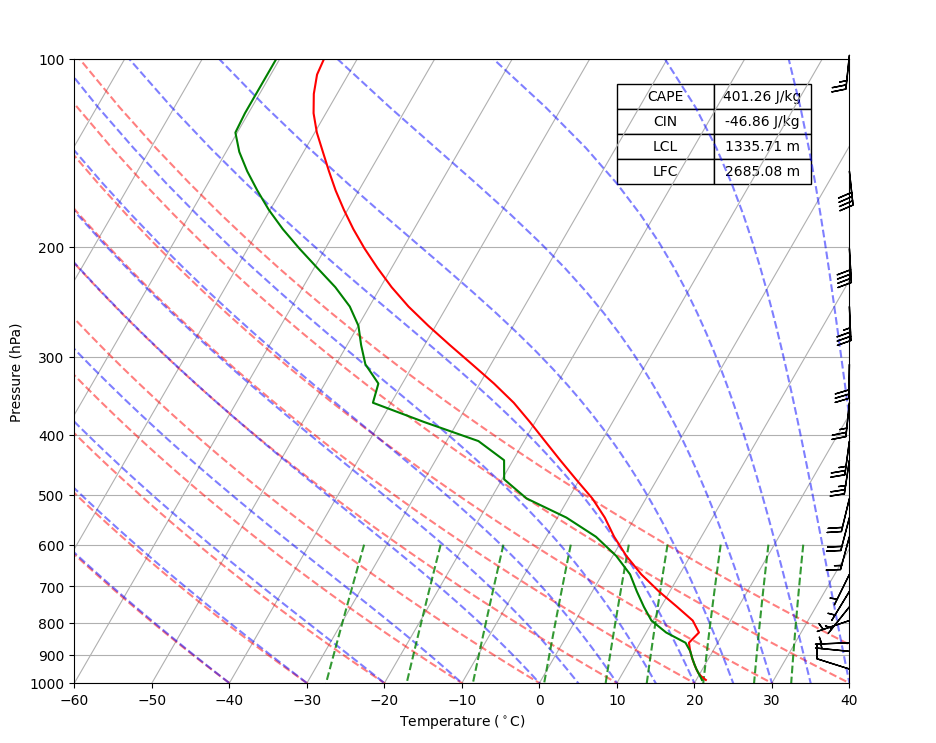

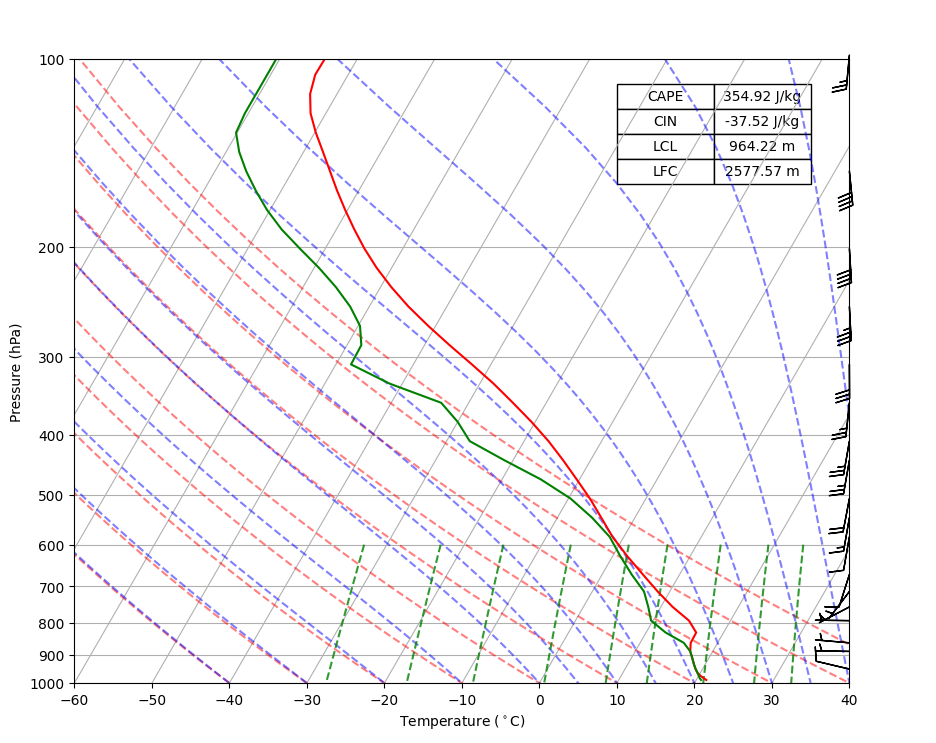

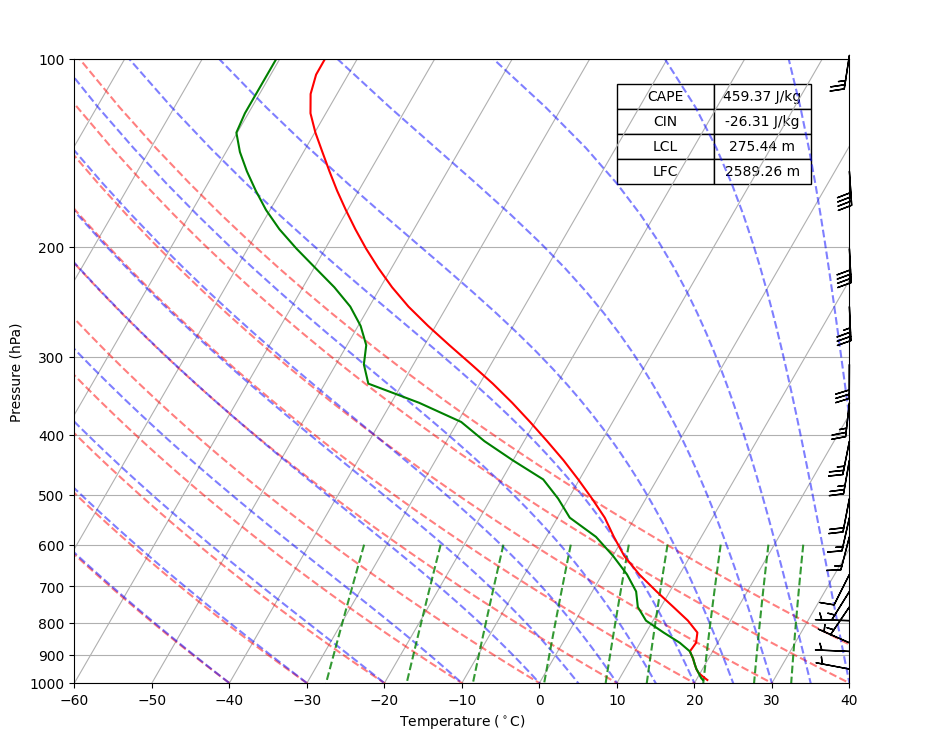

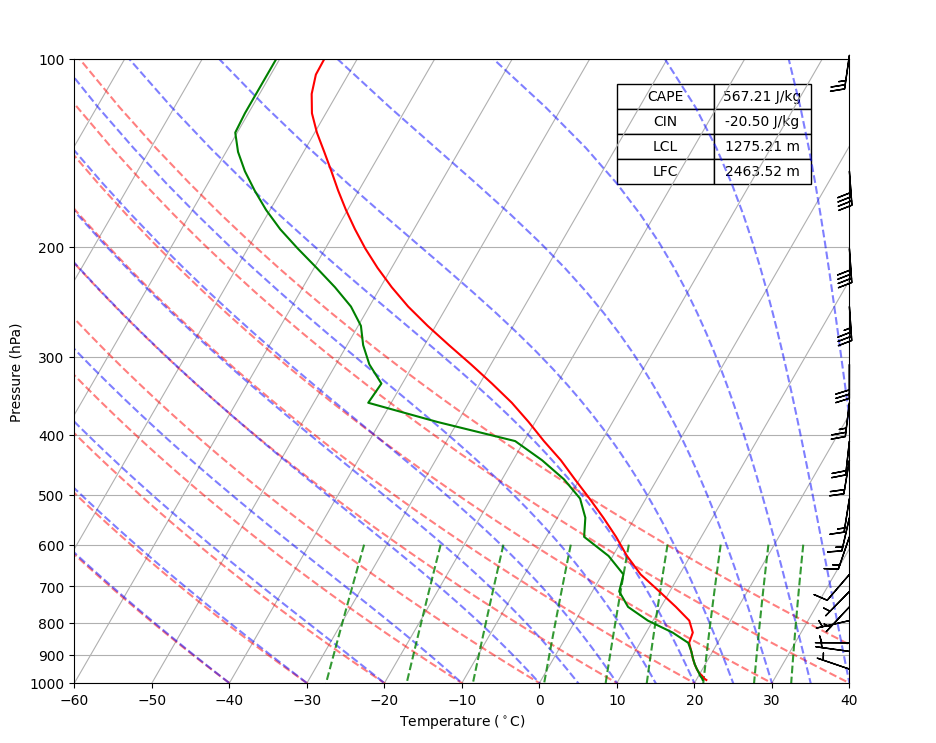

In [29]:
case = 1 # ve cho ngay 17/03

lon = 103.4781
lat = 22.3917
for mp0 in range(4):
    #ax = plt.subplot(2, 2, mp0+1)
    fname =  fd_wrf[case] + mp[case][mp0] + fn_wrf[case] + "15:00:00"
    plt_skewT(lon, lat, fname)
    plt.show()
    